In [80]:
import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [65]:
data1 = pd.read_fwf('local-exp-gl2-data.txt', skiprows=[1], index_col=None)
data2 = pd.read_fwf('local-exp-gl6-data.txt', skiprows=[1], index_col=None)
data = pd.concat([data1, data2], axis=0, ignore_index=True)
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,43243,dpp-local-nc16_gl6-4.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,None
250,43246,dpp-local-nc32_gl6-3.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,None
251,43249,dpp-local-nc32_gl6-10.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,None
252,43252,daa-local-nc16_gl6-9.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,None


In [66]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [67]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [81]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]
data_completed = filter_out_completed_jobs(data)
data_pending = data[data.State == "PENDING"]
data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)

# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_4984\3033834533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


TypeError: argument 1 must be str, not DataFrame

In [69]:
gl2_trials_left = data_completed[data_completed.node == "gl2"].sort_values(
    by=['Workflow', "node", "ncores", "trial"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    # trials_count=('trial', 'count'),
    # trials_list=('trial', lambda x: x.tolist()),
    # trials_left=('trial', lambda x: list(set(range(1, 11)) - set(x.tolist()))),
    trials_left_count=('trial', lambda x: 10 - len(x.tolist())),
).reset_index()
gl2_trials_left.to_csv('gl2_trials_left.csv', index=False, header=True)
gl2_trials_left

,Workflow,mode,ncores,node,trials_left_count
0,daa,local,2,gl2,8
1,daa,local,4,gl2,4
2,daa,local,8,gl2,2
3,dpp,local,2,gl2,8
4,dpp,local,4,gl2,0
5,dpp,local,8,gl2,4


In [70]:
gl6_trials_left = data_completed[data_completed.node == "gl6"].sort_values(
    by=['Workflow', "node", "ncores", "trial"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    # trials_count=('trial', 'count'),
    # trials_list=('trial', lambda x: x.tolist()),
    # trials_left=('trial', lambda x: list(set(range(1, 11)) - set(x.tolist()))),
    trials_left_count=('trial', lambda x: 10 - len(x.tolist())),
).reset_index()
gl6_trials_left.to_csv('gl6_trials_left.csv', index=False, header=True)
gl6_trials_left

,Workflow,mode,ncores,node,trials_left_count
0,daa,local,2,gl6,9
1,daa,local,4,gl6,2
2,daa,local,8,gl6,5
3,daa,local,16,gl6,2
4,daa,local,32,gl6,1
5,dpp,local,2,gl6,9
6,dpp,local,4,gl6,3
7,dpp,local,8,gl6,3
8,dpp,local,16,gl6,2
9,dpp,local,32,gl6,4


In [71]:
# All collected data
collected_data = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).size().reset_index(
    name='count').sort_values(
    by=['Workflow', "node", "ncores"])
collected_data.to_csv('local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,count
0,daa,local,2,gl2,2
2,daa,local,4,gl2,6
4,daa,local,8,gl2,8
1,daa,local,2,gl6,1
3,daa,local,4,gl6,8
5,daa,local,8,gl6,5
6,daa,local,16,gl6,8
7,daa,local,32,gl6,9
8,dpp,local,2,gl2,2
10,dpp,local,4,gl2,10


In [72]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_trials_completed,n_trials_threshold
3,42784.batch,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3990000.0,7.299400e+08,8.838186e+10,...,12728.67,12.72867,10106308.0,10106.308,10.106308,105072,1751.200000,29.186667,2,True
5,42787.batch,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,3980000.0,7.317520e+08,8.838186e+10,...,12728.65,12.72865,10106320.0,10106.320,10.106320,104408,1740.133333,29.002222,2,True
110,42985.batch,daa-local-nc2_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-11-26T08:12:31,2023-11-27T17:38:32,12750000.0,8.893640e+08,8.837861e+10,...,12751.40,12.75140,14981648.0,14981.648,14.981648,120361,2006.016667,33.433611,1,False
1,42781.batch,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245590.0,3.833160e+08,5.345300e+09,...,802.22,0.80222,9676696.0,9676.696,9.676696,7341,122.350000,2.039167,2,True
21,42811.batch,dpp-local-nc2_gl2-7.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T16:51:25,2023-11-29T18:53:24,244550.0,3.840880e+08,5.345300e+09,...,802.22,0.80222,9675836.0,9675.836,9.675836,7319,121.983333,2.033056,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,43060.batch,dpp-local-nc32_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-12-02T18:00:48,2023-12-02T18:22:10,197690.0,3.878652e+09,5.343420e+09,...,804.97,0.80497,193702020.0,193702.020,193.702020,1282,21.366667,0.356111,6,True
202,43147.batch,dpp-local-nc32_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-12-09T07:01:24,2023-12-09T07:22:39,197680.0,3.873032e+09,5.341920e+09,...,804.84,0.80484,193714440.0,193714.440,193.714440,1275,21.250000,0.354167,6,True
204,43150.batch,dpp-local-nc32_gl6-4.cfg,gl2_gl4,gl6,COMPLETED,2023-12-09T07:27:41,2023-12-09T07:48:33,195400.0,3.867044e+09,5.345240e+09,...,804.96,0.80496,193700144.0,193700.144,193.700144,1252,20.866667,0.347778,6,True
224,43183.batch,dpp-local-nc32_gl6-2.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T17:12:45,2023-12-11T17:33:47,196660.0,4.058076e+09,5.341920e+09,...,804.47,0.80447,193714776.0,193714.776,193.714776,1262,21.033333,0.350556,6,True


In [73]:
import matplotlib.pyplot as plt

In [74]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

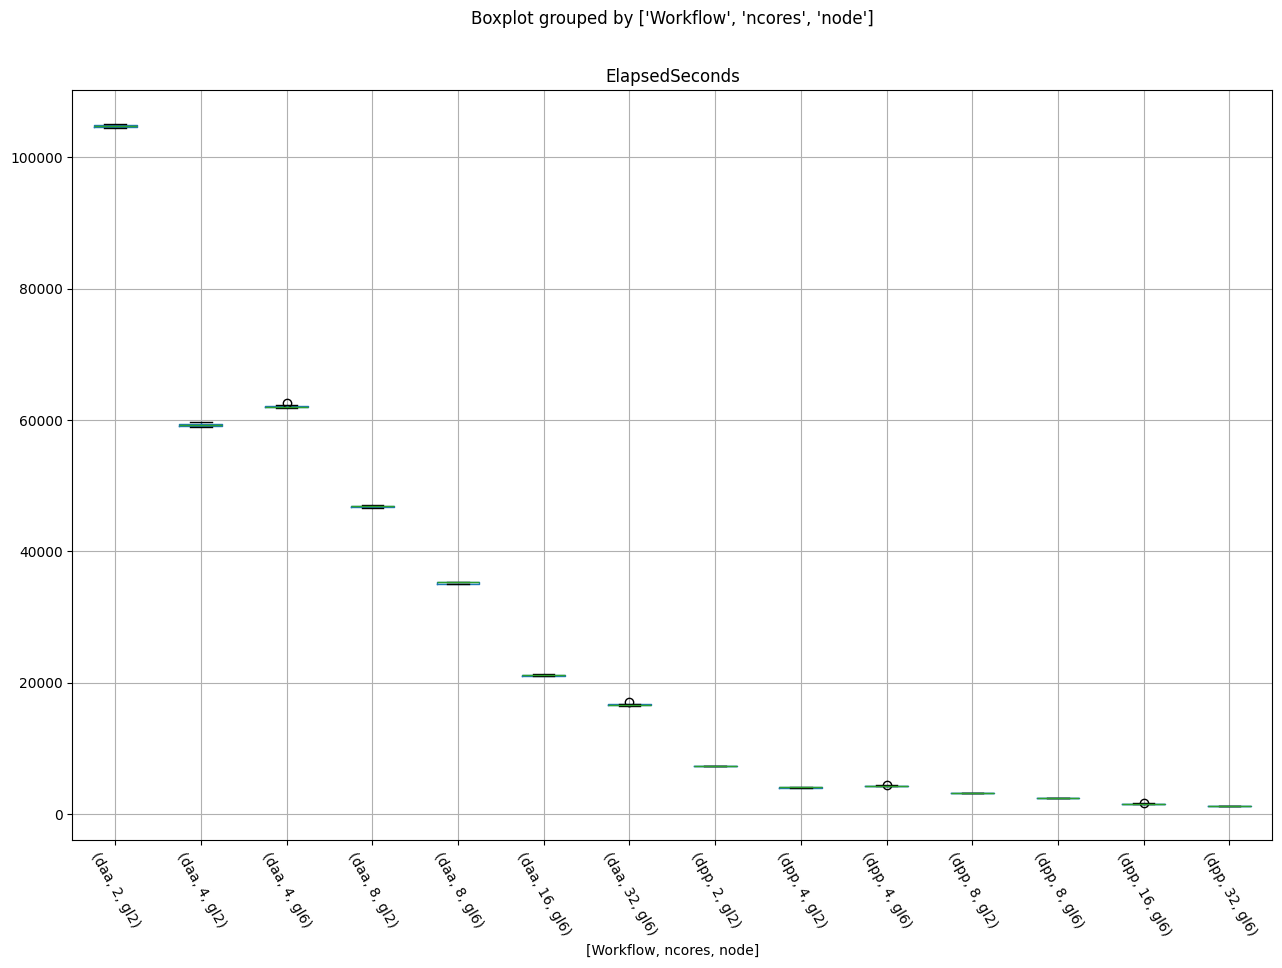

In [78]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('boxplot.png')


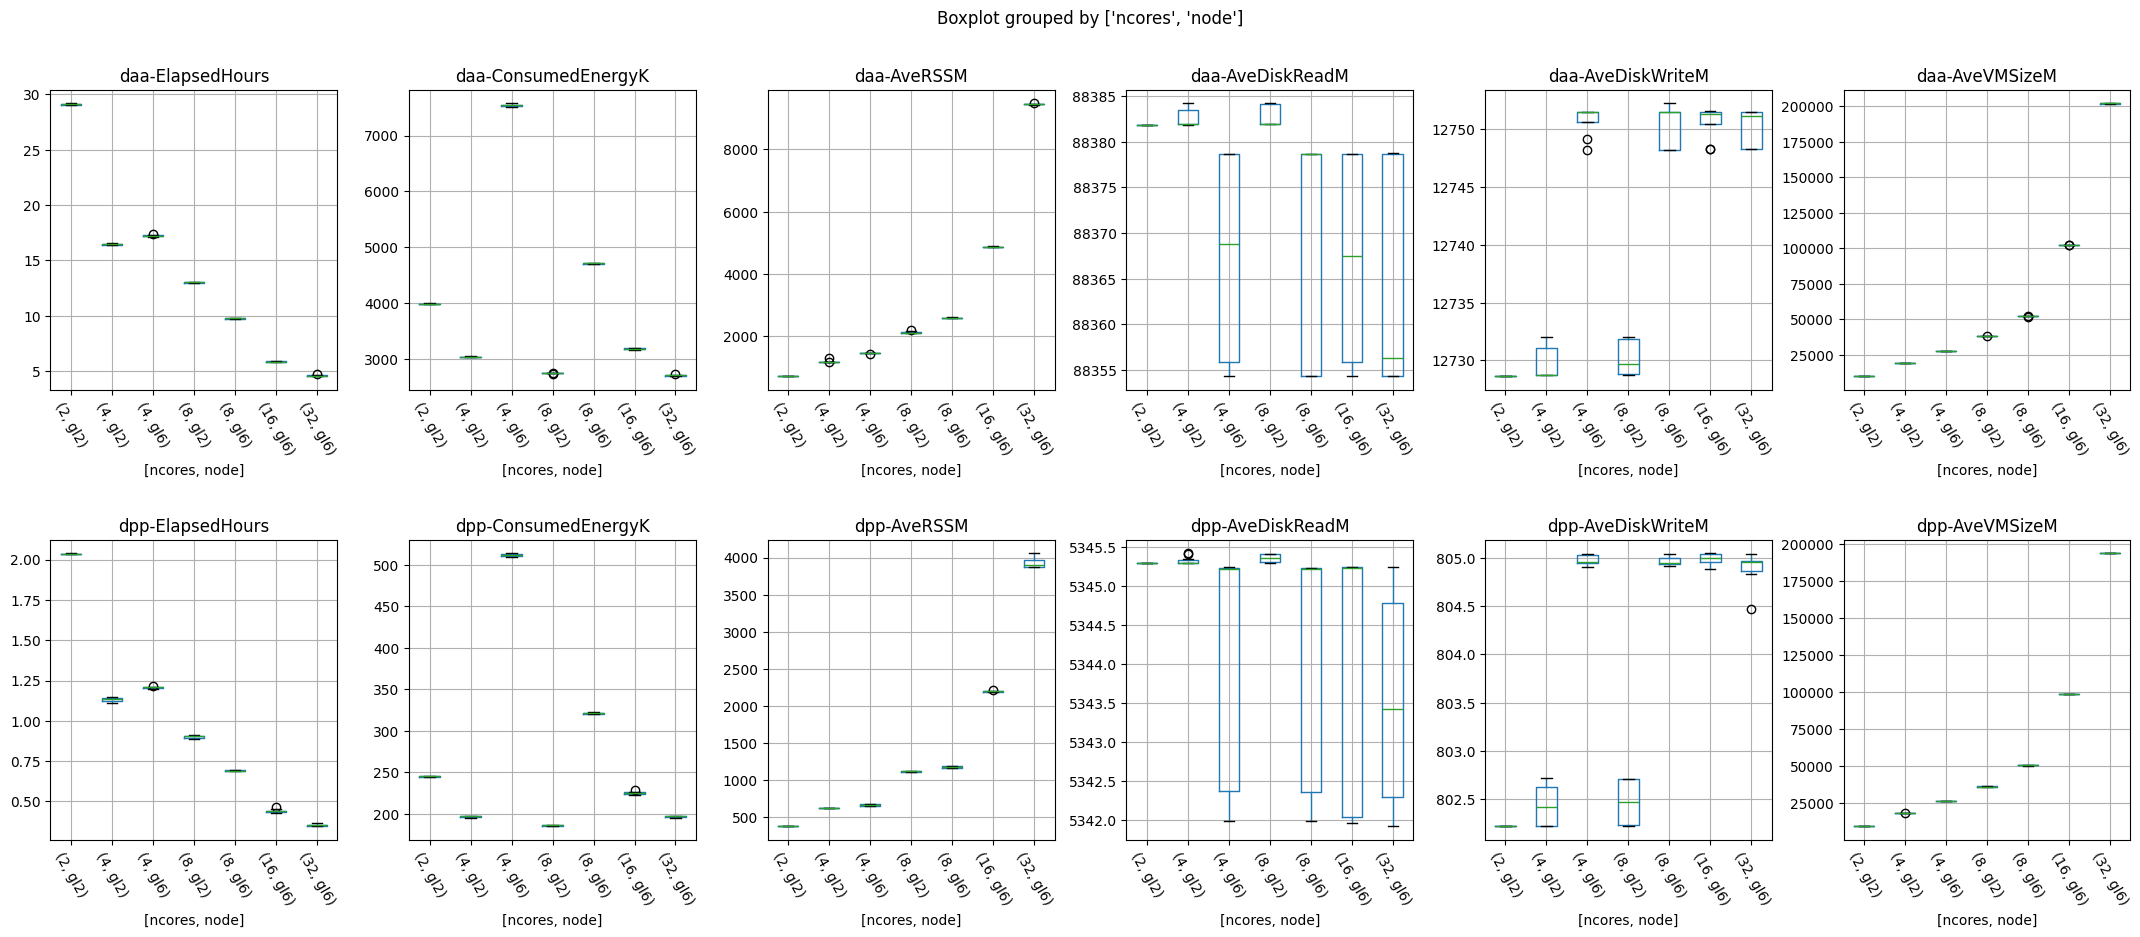

In [76]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('boxplot-overview-by-workflows.png')

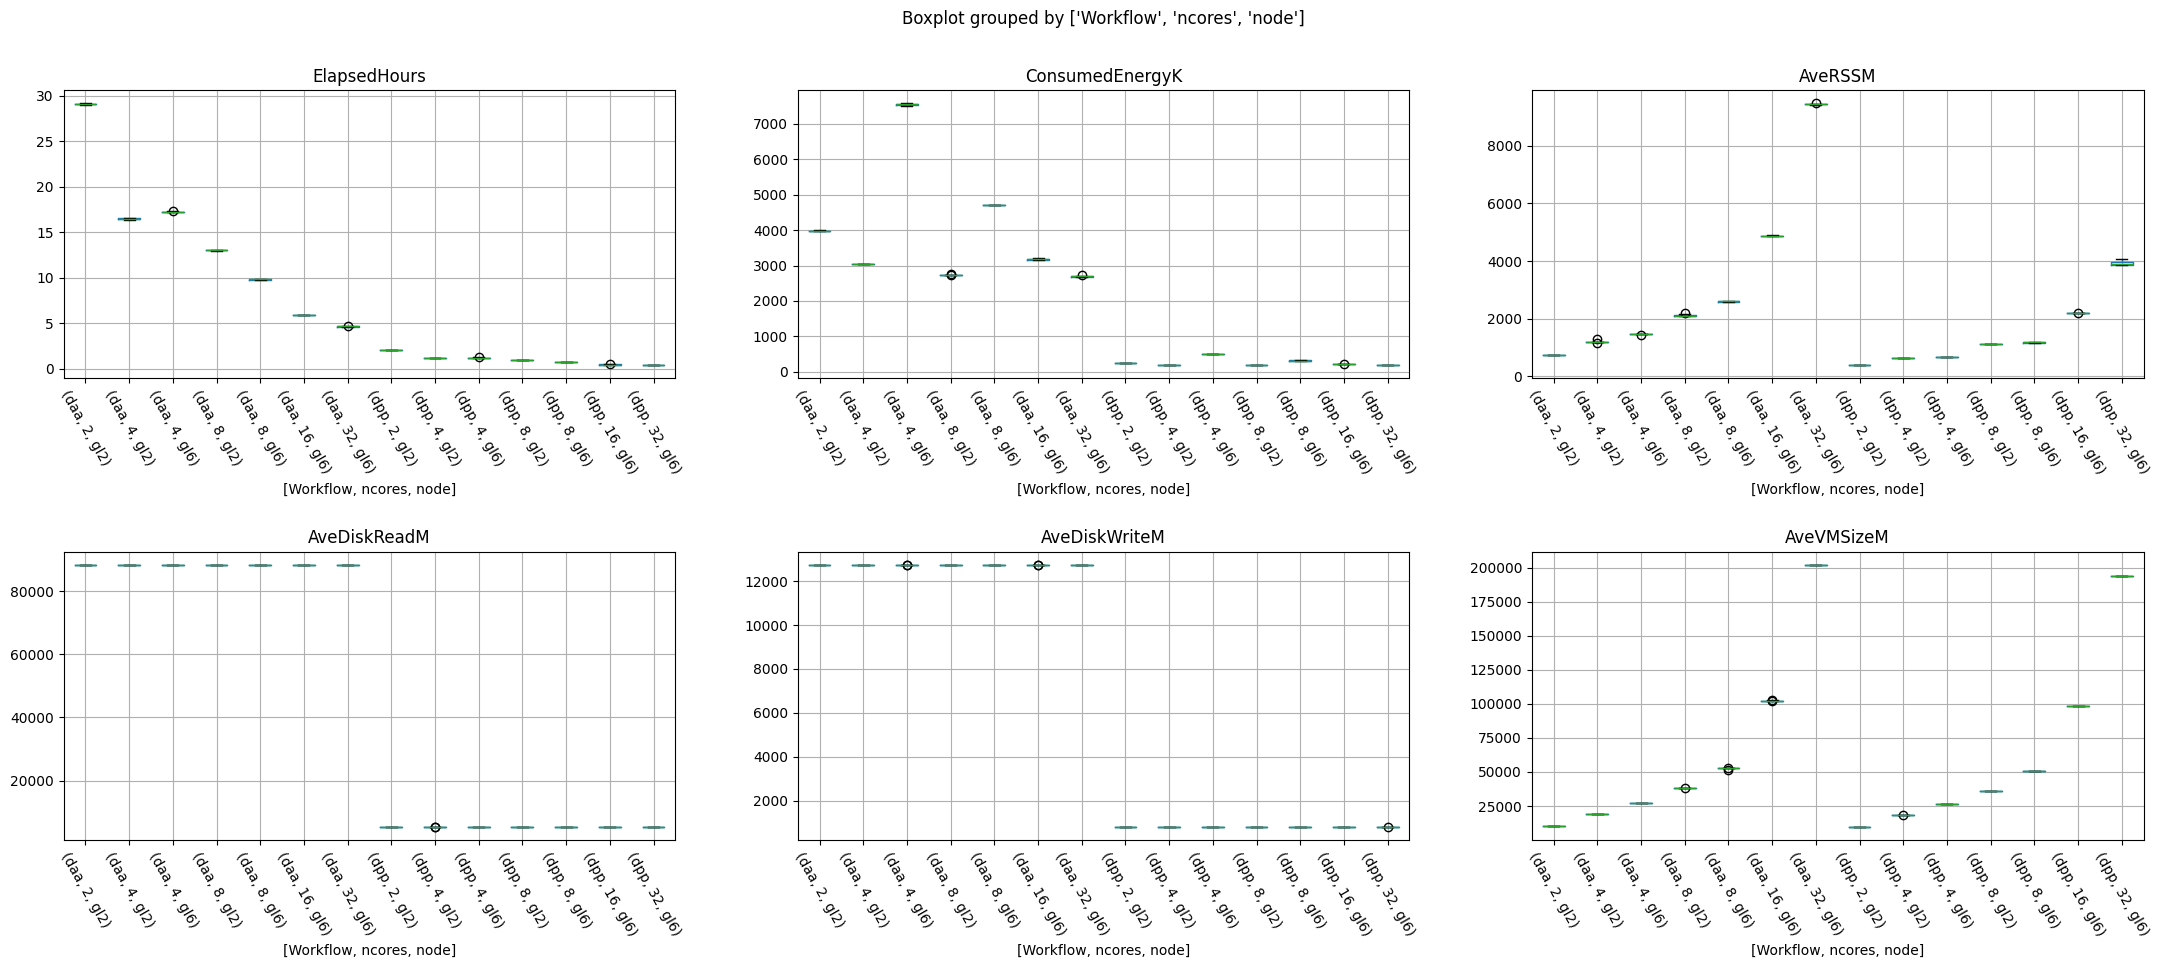

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('boxplot-overview.png')